In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
import os
# os.sys.path.append('/content/drive/MyDrive/Colab Notebooks/OpenCV Sudoku Solver')
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from sudokusolver_norvig_algo import solve, parse_grid, grid_values, squares


# MODEL = load_model('/content/drive/MyDrive/Colab Notebooks/OpenCV Sudoku Solver/keras_MNIST_trained.h5')
MODEL = load_model('G:\My Drive\Colab Notebooks\OpenCV Sudoku Solver\keras_MNIST_trained.h5')

def prepare_img(img):
  img = cv2.resize(img, (28, 28)).astype("float") / 255.0
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)
  return img


def preprocess_sudoku_grid(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, (7, 7), 3)
  # plt.imshow(gray,cmap='gray')
  thresh = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
  thresh = cv2.bitwise_not(thresh)
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
      output = img.copy()
      # cv2.drawContours(output, [approx], -1, (0, 255, 0), 7)
      # plt.imshow(output,cmap='gray')
      og_img_grid = four_point_transform(img, approx.reshape(4, 2))
      grid = four_point_transform(gray, approx.reshape(4, 2))
      # plt.imshow(grid,cmap='gray')
      return grid
    else:
      pass
      # print("No contours found!")

def extract_cells(grid):
  cell_content = {}
  H,W = grid.shape # H,W
  cell_height = H//9
  cell_width = W//9
  for rw in range(0, H , cell_height):
    if rw+cell_height < H:
      row = grid[rw:rw+cell_height]
      for cl in range(0, W , cell_width):
        if cl+cell_width < W:
          cell = row[:,cl:cl+cell_width]
          cell_th = cv2.threshold(cell, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
          cell_th = clear_border(cell_th)
          digit = None
          cnts = cv2.findContours(cell_th.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
          cnts = imutils.grab_contours(cnts)
          if not (len(cnts)==0):
            c = max(cnts, key=cv2.contourArea)
            mask = np.zeros(cell_th.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)
            h, w = cell_th.shape
            percentFilled = cv2.countNonZero(mask) / float(w * h)
            if percentFilled > 0.03: # then not noise
              digit = cv2.bitwise_and(cell_th, cell_th, mask=mask)
          coords = (rw,rw+cell_height,cl,cl+cell_width)
          cell_content[coords]=digit
  return cell_content
          

def get_str_grid(cells):
  pred_grid = []
  empty_cells = {}
  for sq,(coords,cell) in zip(squares,cells.items()):
    if cell is None:
      pred_grid.append('.')
      empty_cells[sq] = coords
    else:
      inp = prepare_img(cell)
      pred = MODEL.predict(inp).argmax(axis=1)[0]+1
      pred_grid.append(str(pred))
  str_grid = "".join(pred_grid)
  # display(grid_values(str_grid))
  return str_grid,empty_cells


### From Camera #colab

In [16]:
# # import dependencies
# from IPython.display import display, Javascript, Image
# from google.colab.output import eval_js
# from base64 import b64decode, b64encode
# import cv2
# import numpy as np
# import PIL
# import io
# import html
# import time

# # function to convert the JavaScript object into an OpenCV image
# def js_to_image(js_reply):
#   """
#   Params:
#           js_reply: JavaScript object containing image from webcam
#   Returns:
#           img: OpenCV BGR image
#   """
#   # decode base64 image
#   image_bytes = b64decode(js_reply.split(',')[1])
#   # convert bytes to numpy array
#   jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
#   # decode numpy array into OpenCV BGR image
#   img = cv2.imdecode(jpg_as_np, flags=1)

#   return img

# # function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
# def bbox_to_bytes(bbox_array):
#   """
#   Params:
#           bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
#   Returns:
#         bytes: Base64 image byte string
#   """
#   # convert array into PIL image
#   bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
#   iobuf = io.BytesIO()
#   # format bbox into png for return
#   bbox_PIL.save(iobuf, format='png')
#   # format return string
#   bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

#   return bbox_bytes

#   # JavaScript to properly create our live video stream using our webcam as input
# def video_stream():
#   js = Javascript('''
#     var video;
#     var div = null;
#     var stream;
#     var captureCanvas;
#     var imgElement;
#     var labelElement;
    
#     var pendingResolve = null;
#     var shutdown = false;
    
#     function removeDom() {
#        stream.getVideoTracks()[0].stop();
#        video.remove();
#        div.remove();
#        video = null;
#        div = null;
#        stream = null;
#        imgElement = null;
#        captureCanvas = null;
#        labelElement = null;
#     }
    
#     function onAnimationFrame() {
#       if (!shutdown) {
#         window.requestAnimationFrame(onAnimationFrame);
#       }
#       if (pendingResolve) {
#         var result = "";
#         if (!shutdown) {
#           captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
#           result = captureCanvas.toDataURL('image/jpeg', 0.8)
#         }
#         var lp = pendingResolve;
#         pendingResolve = null;
#         lp(result);
#       }
#     }
    
#     async function createDom() {
#       if (div !== null) {
#         return stream;
#       }

#       div = document.createElement('div');
#       div.style.border = '2px solid black';
#       div.style.padding = '3px';
#       div.style.width = '100%';
#       div.style.maxWidth = '600px';
#       document.body.appendChild(div);
      
#       const modelOut = document.createElement('div');
#       modelOut.innerHTML = "<span>Status:</span>";
#       labelElement = document.createElement('span');
#       labelElement.innerText = 'No data';
#       labelElement.style.fontWeight = 'bold';
#       modelOut.appendChild(labelElement);
#       div.appendChild(modelOut);
           
#       video = document.createElement('video');
#       video.style.display = 'block';
#       video.width = div.clientWidth - 6;
#       video.setAttribute('playsinline', '');
#       video.onclick = () => { shutdown = true; };
#       stream = await navigator.mediaDevices.getUserMedia(
#           {video: { facingMode: "environment"}});
#       div.appendChild(video);

#       imgElement = document.createElement('img');
#       imgElement.style.position = 'absolute';
#       imgElement.style.zIndex = 1;
#       imgElement.onclick = () => { shutdown = true; };
#       div.appendChild(imgElement);
      
#       const instruction = document.createElement('div');
#       instruction.innerHTML = 
#           '<span style="color: red; font-weight: bold;">' +
#           'When finished, click here or on the video to stop this demo</span>';
#       div.appendChild(instruction);
#       instruction.onclick = () => { shutdown = true; };
      
#       video.srcObject = stream;
#       await video.play();

#       captureCanvas = document.createElement('canvas');
#       captureCanvas.width = 640; //video.videoWidth;
#       captureCanvas.height = 480; //video.videoHeight;
#       window.requestAnimationFrame(onAnimationFrame);
      
#       return stream;
#     }
#     async function stream_frame(label, imgData) {
#       if (shutdown) {
#         removeDom();
#         shutdown = false;
#         return '';
#       }

#       var preCreate = Date.now();
#       stream = await createDom();
      
#       var preShow = Date.now();
#       if (label != "") {
#         labelElement.innerHTML = label;
#       }
            
#       if (imgData != "") {
#         var videoRect = video.getClientRects()[0];
#         imgElement.style.top = videoRect.top + "px";
#         imgElement.style.left = videoRect.left + "px";
#         imgElement.style.width = videoRect.width + "px";
#         imgElement.style.height = videoRect.height + "px";
#         imgElement.src = imgData;
#       }
      
#       var preCapture = Date.now();
#       var result = await new Promise(function(resolve, reject) {
#         pendingResolve = resolve;
#       });
#       shutdown = false;
      
#       return {'create': preShow - preCreate, 
#               'show': preCapture - preShow, 
#               'capture': Date.now() - preCapture,
#               'img': result};
#     }
#     ''')

#   display(js)
  
# def video_frame(label, bbox):
#   data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
#   return data

In [17]:
# # start streaming video from webcam
# video_stream()
# # label for video
# label_html = 'Capturing...'
# # initialze bounding box to empty
# bbox = ''
# count = 0 
# while True:
#     js_reply = video_frame(label_html, bbox)
#     if not js_reply:
#         break

#     # convert JS response to OpenCV Image
#     img = js_to_image(js_reply["img"])
#     bbox_array = cv2.putText(img=img, text="value", org=(100,100), fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=8, color=(0, 0, 0),thickness=1)
#     # grid = preprocess_sudoku_grid(img)
#     # try:
#     #   cells = extract_cells(grid)
#     #   str_grid, empty_cells = get_str_grid(cells)
#     #   res = solve(str_grid,print_res=False)
#     #   empty_cell_values = {coords:res[sq] for sq,coords in empty_cells.items()}
#       # for coords,value in empty_cell_values.items():
#       #   org = (coords[2]+20,coords[1]-10)
#       #   bbox_array = cv2.putText(img=img, text=value, org=org, fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 0),thickness=1)
#     bbox_array[:,:,2] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
#     # convert overlay of bbox into bytes
#     bbox_bytes = bbox_to_bytes(bbox_array)
#     # update bbox so next frame gets new overlay
#     bbox = bbox_bytes
#     # except:
#     #   pass
    

### From Camera #local webcam

In [18]:
# cap = cv2.VideoCapture(0)

# while True:
#     ret, img = cap.read()
#     grid = preprocess_sudoku_grid(img)
#     try:
#       cells = extract_cells(grid)
#       str_grid, empty_cells = get_str_grid(cells)
#       res = solve(str_grid,print_res=False)
#       empty_cell_values = {coords:res[sq] for sq,coords in empty_cells.items()}
#       for coords,value in empty_cell_values.items():
#         org = (coords[2]+20,coords[1]-10)
#         cv2.putText(img=img, text=value, org=org, fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 0),thickness=1)
#         cv2.imshow('Webcam', img)
#     except:
#         pass

#     c = cv2.waitKey(1)
#     if c == 27:
#         break

# cap.release()
# cv2.destroyAllWindows()

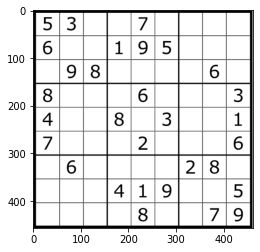

In [19]:
# PATH = '/content/drive/MyDrive/Colab Notebooks/OpenCV Sudoku Solver/test_examples/level_easy_0.png'
PATH = 'test_examples\level_easy_0.png'

# OPEN IMAGE FROM FILE
image = cv2.imread(PATH)
plt.imshow(image,cmap='gray')

In [20]:
grid = preprocess_sudoku_grid(image)

In [21]:
cells = extract_cells(grid)

In [22]:
str_grid, empty_cells = get_str_grid(cells)

1/1 [==============================] - 0s 16ms/step


In [23]:
str_grid

'53..7....6..195....98....6.8...6...34..8.3..17...2...6.6....28....419..5....8..79'

5 3 4 |6 7 8 |9 1 2 
6 7 2 |1 9 5 |3 4 8 
1 9 8 |3 4 2 |5 6 7 
------+------+------
8 5 9 |7 6 1 |4 2 3 
4 2 6 |8 5 3 |7 9 1 
7 1 3 |9 2 4 |8 5 6 
------+------+------
9 6 1 |5 3 7 |2 8 4 
2 8 7 |4 1 9 |6 3 5 
3 4 5 |2 8 6 |1 7 9 


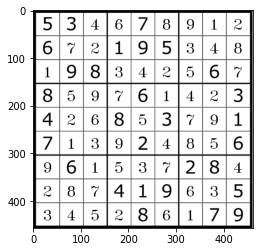

In [24]:
res = solve(str_grid,print_res=True)
empty_cell_values = {coords:res[sq] for sq,coords in empty_cells.items()}

# OUTPUT IMAGE
copy_ = image.copy()
plt.figure()
for coords,value in empty_cell_values.items():
    org = (coords[2]+20,coords[1]-10)
    cv2.putText(img=copy_, text=value, org=org, fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=1, color=(0, 0, 0),thickness=1)
plt.imshow(copy_)